In [1]:
#!pip install ipython-autotime
#!pip install umap-learn
#!pip install boto3
#!pip install sagemaker
#!pip install awscli

%load_ext autotime

import operator

import tensorflow as tf

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import scipy
import pandas as pd
import numpy as np
import pickle
import string
import matplotlib.pyplot as plt

import nltk
nltk.download('words')
from nltk.corpus import words
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

import umap
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors
from random import randrange

from keras.models import load_model

import boto3 
import boto3.session
import s3fs
import sagemaker
from sagemaker import get_execution_role

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\zvnow\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
Using TensorFlow backend.


In [ ]:
# Download models and data from S3 bucket where training output was saved
s3=boto3.client('s3')
list_ob = s3.list_objects(Bucket='sagemaker-textgenerator')['Contents'] 
for key in list_ob:
    s3.download_file('sagemaker-textgenerator', key['Key'], key['Key'])
    print(key['Key'])

In [2]:
# Defining function to explore clusters
def show_me():
    num_art = 400
    cluster_map_new = pd.read_pickle(f'cluster_map_new_{num_art}.pkl') 
    for num in range(cluster_map_new['KNN_Clusters'].nunique()):
        print(f'The Most Frequently Used Words in the Titles assigned to Cluster {num} are:')
        text = " ".join(item for item in cluster_map_new.loc[cluster_map_new['KNN_Clusters']==num].Title_str)
        wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(text)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        print(' ')

# Defining sampling function to tune output
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# Defining function to write articles
def write_article(words_number):
    # Define number of articles in each cluster, 400 or 500, depending on your training setup
    num_art = 400
    # Define sequence length, must be the same size as the sequence length used during model training
    seq_length = 4
    # Define Acceptable Probability for generating next word, range from 0.1 to 1
    percent_pred = 1
    # Set the length of the article to generate
    words_number = words_number

    generated_clean = ''
    punct = ['!', "''", '#', '$', '%','&',"'",'(',')','*','+',',','-','.',',','/',':',';','<','=','>','?','@','[','\\',']','^','_','`','{','|','}','~']
    stop_words = list(set(stopwords.words('english')))
    stop_w = stop_words + punct
    cluster_map_new = pd.read_pickle(f'cluster_map_new_{num_art}.pkl')

    word_str = input("Choose some keywords for your Article here: ")
    print(' ')
    art_title = word_str.replace('\n', ' ').replace('  ', ' ').lower()
    art_list = word_tokenize(art_title)
    art_list = [x for x in art_list if x not in stop_w]
    art_list = [x for x in art_list if len(x) > 2]
    art_list = [x for x in art_list if x.isalpha()]
    generated_clean += ' '.join(art_list)
    count = 0
    list_num = []
    dict_count = {}
    for num in range(cluster_map_new['KNN_Clusters'].nunique()):
        long_str = ' '.join(cluster_map_new.loc[cluster_map_new['KNN_Clusters']==num].Content)
        for item in art_list:
            count = long_str.count(item)
            dict_count[f'{item}-{num}'] = count
    amount = 0
    new_dict_count = {}
    for key, value in dict_count.items():
        list_num.append([int(key.split('-')[1]), value])
    count_num = 0
    count_dict_new = {}
    for num in range(0,10):
        count_num = 0
        for item in list_num:
            if item[0] == num:
                count_num += item[1] 
                count_dict_new[f'clust-{num}'] = count_num
                
    num = max(count_dict_new.items(), key=operator.itemgetter(1))[0]
    num = int(num.split('-')[1])
    
    print(f"Your Article has been assigned Cluster #{num}")
    print(' ')
    print(f'The Most Frequently Used Words in the Titles assigned to Cluster {num} are:')
    text = " ".join(item for item in cluster_map_new.loc[cluster_map_new['KNN_Clusters']==num].Title_str)
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off")
    plt.show()
    print(' ')
    vocab_dict = pickle.load(open(f'vocab_dict_clust_{num}_{num_art}.pkl', "rb"))
    print("Vocab Size Loaded")
    print(' ')
    vocab = pickle.load(open(f'vocabulary_clust_{num}_{num_art}.pkl', "rb"))
    print("Vocabulary Loaded")
    print(' ')
    vocabulary_inv = pickle.load(open(f'vocabulary_inv_clust_{num}_{num_art}.pkl', "rb"))
    print("Vocabulary Inverse Dict Loaded")
    print(' ')
    vocab_size = vocab_dict[f"cluster_num_{num}_{num_art}"]
    print(f'The Size of the Vocabulary in the Cluster is {vocab_size}')
    print(' ')
    print('Loading LSTM Model...')
    model = load_model(f"saved-model-clust-{num}_{num_art}.h5")
    print('LSTM Model Loaded')
    print(' ')

    while True:
        try:
            generated = ''
            testVar = input("Type the first 6 words of your article here: ")
            seed_sentences = testVar.lower().replace("-", " ").split()
            sentence = seed_sentences[:seq_length]
            generated += ' '.join(sentence)
            for i in range(words_number):
            #create the vector
                x = np.zeros((1, seq_length, vocab_size))
                for t, word in enumerate(sentence):
                    x[0, t, vocab[word]] = 1
                #calculate next word
                preds = model.predict(x, verbose=0)[0]
                next_index = sample(preds, percent_pred)
                next_word = vocabulary_inv[next_index]
                #add the next word to the text
                generated += " " + next_word
                #shift the sentence by one, and add the next word at its end
                sentence = sentence[1:] + [next_word]
            print(' ')
            print( '. '.join(map(lambda s: s.strip().capitalize(), generated.split('.'))))      
            break
        except:
            print('Word in Content not in Vocab')
            continue

time: 15.6 ms


Choose some keywords for your Article here: how many houses can be built in two days
 
Your Article has been assigned Cluster #6
 
The Most Frequently Used Words in the Titles assigned to Cluster 6 are:


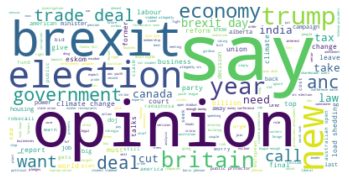

 
Vocab Size Loaded
 
Vocabulary Loaded
 
Vocabulary Inverse Dict Loaded
 
The Size of the Vocabulary in the Cluster is 22122
 
Loading LSTM Model...
LSTM Model Loaded
 
Type the first 6 words of your article here: how many houses can be built in two days
 
How many houses can 25 and us towers, the most ad revolutionary what was demanding causes leo rights had cited with ksf to terms against eu solution and they can be fined, security at her law, what they can do presented and his company’s shot, at 44% after brain disapproval practice at eu in tax an supply last year at 2015 and then, they’re fails to bring down the america or committed to tax 17 – but we do that. It’s a huge down for macron, for crimes for written million among the green countries with the arizona climate world road elections in august project, during a scene after the person presented on the door is in full action to exclude their hanson who openly any 2 via sign up wiradjuri arena judge prieto tariffs she got up to

In [3]:
write_article(200)